In [3]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

In [4]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

In [5]:
import os
 
# Get all book files in the data directory
all_books = [b for b in os.scandir('data') 
             if '.txt' in b.name]

In [6]:
all_books

[<DirEntry '01.Harry Potter and the Sorcerer’s Stone.txt'>,
 <DirEntry '02.Harry Potter and the Chamber of Secrets.txt'>,
 <DirEntry '03.Harry Potter and the Prisoner of Azkaban.txt'>,
 <DirEntry '04.Harry Potter and the Goblet of Fire.txt'>,
 <DirEntry '05.Harry Potter and the Order of the Phoenix.txt'>,
 <DirEntry '06.Harry Potter and the Half-Blood Prince.txt'>,
 <DirEntry '07.Harry Potter and the Deathly Hallows.txt'>]

In [7]:
all_books[1]

<DirEntry '02.Harry Potter and the Chamber of Secrets.txt'>

In [8]:
# book=all_books[1]
# book_text=open(book,"r")
# print(book_text.readlines())
# book_text.close()

In [9]:
book= all_books[0]
book_text=open(book, encoding="utf8").read()
book_doc = NER(book_text)

In [10]:
#visualize identified entities

displacy.render(book_doc[0:2000],style='ent',jupyter=True)

# Load character names

In [11]:
character_df = pd.read_csv("characters.csv")
import re
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [12]:
character_df[~(character_df['character_firstname'] !='Tom')]

character character_firstname
1553  Tom Marvolo Riddle                 Tom
1804                 Tom                 Tom
1805    Tom (Bowtruckle)                 Tom
1806  Tom Marvolo Riddle                 Tom
1807      Tom Riddle Sr.                 Tom

# data cleaning

In [13]:
#dopping rows where character column has family
from operator import index


character_df=character_df[~character_df.character.str.contains("family")]

#dropping rows which have brackets
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 

#keeping the full name in firstname column if it has mrs or mr
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Mrs.', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Mrs', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df.character.str.contains("'"), character_df['character'], character_df['character_firstname'])

character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Mr.', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Sir', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'The', character_df['character'], character_df['character_firstname'])
character_df['character_firstname'] = np.where(character_df['character_firstname'] == 'Professor', character_df['character'], character_df['character_firstname'])

character_df=character_df[character_df['character_firstname']!='Slytherin']

# character_df.loc[index,:]=[89,21,87,59]

#removing rows where the character name string starts with lower case (hence not a name)
character_df = character_df[~character_df['character'].str[0].str.islower()]

#keeping rows where character string<3
character_df = character_df[character_df['character'].str.split().str.len().lt(5)]

#dropping duplicate rows
character_df=character_df.drop_duplicates()

character_df=character_df.reset_index(drop=True)

pd.set_option('display.max_rows', None)
character_df.shape[0]
character_df

character              character_firstname
0                         Mrs. Abbott                      Mrs. Abbott
1                       Hannah Abbott                           Hannah
2                       Abel Treetops                             Abel
3                    Euan Abercrombie                             Euan
4                Aberforth Dumbledore                        Aberforth
5                           Abernathy                        Abernathy
6                   Abraham Peasegood                          Abraham
7                      Abraham Potter                          Abraham
8                      Abraxas Malfoy                          Abraxas
9                   Achilles Tolliver                         Achilles
10                   Stewart Ackerley                          Stewart
11                  Adalbert Waffling                         Adalbert
12                       Adrian Pucey                           Adrian
13                      Adrian Tutley                           Adrian
14                       Agatha Chubb                           Agatha
15                       Agatha Timms                           Agatha
16                  Agilbert Fontaine                         Agilbert
17                              Agnes                            Agnes
18                  Cornelius Agrippa                        Cornelius
19                        Aidan Kiely                            Aidan
20                        Aidan Lynch                            Aidan
21                   Alasdair Maddock                         Alasdair
22                    Alastor Gumboil                          Alastor
23                      Mad-Eye Moody                          Mad-Eye
24                   Albanian peasant                         Albanian
25                   Alberic Grunnion                          Alberic
26                   Alberta Toothill                          Alberta
27                        Albert Boot                           Albert
28                     Albert Jorkins                           Albert
29                     Albert Runcorn                           Albert
30                    Albert Tillyman                           Albert
31                   Albus Dumbledore                            Albus
32                       Albus Potter                            Albus
33                           Alderton                         Alderton
34                     Arkie Alderton                            Arkie
35                      Alecto Carrow                           Alecto
36                  Alfred Cattermole                           Alfred
37                   Alguff the Awful                           Alguff
38                         Ali Bashir                              Ali
39                   Alice Longbottom                            Alice
40                     Alicia Spinnet                           Alicia
41                        Aliko Okoye                            Aliko
42                       Raul Almeida                             Raul
43                 Almerick Sawbridge                         Almerick
44                   Alejandra Alonso                        Alejandra
45                      Alphard Black                          Alphard
46                            Altheda                          Altheda
47                   Amarillo Lestoat                         Amarillo
48                              Amata                            Amata
49                    Ambrosius Flume                        Ambrosius
50                 Amelia Susan Bones                           Amelia
51                       Amos Diggory                             Amos
52                         Amy Benson                              Amy
53                      Amycus Carrow                           Amycus
54                      P.C. Anderson                             P.C.
55        Andorran Minister for Magic               

In [14]:
character_df=character_df[~(character_df['character_firstname']=='Harold')]

In [15]:
 #checking number of duplicates 
# character_df["duplicate_value"] = 1
# character_df_values=character_df.groupby(["character","character_firstname"], sort=False, as_index=False).sum()
# character_df_values[character_df_values['duplicate_value']>1]

In [16]:
# for i in range (1946):
#     if character_df['character_firstname'][i]=='Mrs.':
#         #character_df.character_firstname[i].replace(to_replace='Mrs', value=character_df.character[i])#, regex=True)
#         #character_df.character_firstname[i].replace('Mrs.',character_df.character[i])
       
#         character_df['character_firstname'][i] = character_df['character_firstname'][i].replace(character_df['character'][i])

# get the entity list per sentence

In [17]:
sent_entity=[]

for sent in book_doc.sents:
    entity_list=[ent.text for ent in sent.ents]
    sent_entity.append({"sentence":sent,"entities":entity_list})
    
sent_entity_df=pd.DataFrame(sent_entity)


In [18]:
sent_entity_df

sentence  \
0     (/, \n\n\n\n\n, THE, BOY, WHO, LIVED, \n\n, Mr...   
1     (They, were, the, last, people, you, ’d, \n, e...   
2     (Mr., Dursley, was, the, director, of, a, firm...   
3     (He, was, a, big, ,, beefy, \n, man, with, har...   
4     (Mrs., Dursley, was, thin, and, \n, blonde, an...   
5     (The, Dursley, s, had, a, small, son, \n, call...   
6                                                (\n\n)   
7     (The, Dursleys, had, everything, they, wanted,...   
8     (They, did, n’t, think, they, \n, could, bear,...   
9     (Mrs., Potter, was, Mrs., Dursley, ’s, sister,...   
10    (The, Dursleys, shuddered, to, think, \n, what...   
11    (The, Dursleys, knew, that, the, Potters, had,...   
12                                               (\n\n)   
13    (This, boy, was, another, good, reason, for, k...   
14                                               (\n\n)   
15    (When, Mr., and, Mrs., Dursley, woke, up, on, ...   
16    (Mr., Dursley, hummed, as, he, picked, out, \n...   
17                                               (\n\n)   
18    (None, of, them, noticed, a, large, ,, tawny, ...   
19    (\n\n, At, half, past, eight, ,, Mr., Dursley,...   
20    (“, Little, tyke, ,, ”, chortled, Mr., Dursley...   
21    (He, got, into, his, car, and, backed, \n, out...   
22                                               (\n\n)   
23    (It, was, on, the, corner, of, the, street, th...   
24    (For, a, second, ,, Mr., Dursley, did, n’t, re...   
25    (There, was, a, tabby, cat, standing, on, the,...   
26    (What, \n, could, he, have, been, thinking, of...   
27    (It, must, have, been, a, \n, trick, of, the, ...   
28    (Mr., Dursley, blinked, and, stared, at, \n, P...   
29                                (It, stared, back, .)   
30    (As, Mr., Dursley, drove, around, \n, the, cor...   
31    (It, was, now, reading, the, sign, that, said,...   
32    (Mr., Dursley, gave, himself, a, little, shake...   
33    (As, he, drove, toward, \n, town, he, thought,...   
34                                               (\n\n)   
35    (But, on, the, edge, of, town, ,, drills, were...   
36    (As, he, sat, in, the, usual, \n, morning, tra...   
37                              (People, in, cloaks, .)   
38    (Mr., Dursley, could, n’t, bear, \n, people, w...   
39    (He, supposed, this, was, some, \n, stupid, ne...   
40    (He, drummed, his, fingers, on, the, \n, steer...   
41    (They, were, whispering, \n, excitedly, togeth...   
42    (Mr., Dursley, was, enraged, to, see, \n, that...   
43                             (The, nerve, of, him, !)   
44    (But, then, it, \n, struck, Mr., Dursley, that...   
45                     (yes, ,, that, would, be, it, .)   
46    (The, traffic, moved, \n, on, and, a, few, min...   
47    (Mr., Dursley, always, sat, with, his, back, t...   
48    (If, he, had, n’t, ,, he, might, \n, have, fou...   
49    (He, did, n’t, see, the, owls, swooping, past,...   
50    (Most, of, them, had, never, seen, an, \n, owl...   
51    (Mr., Dursley, ,, however, ,, had, a, \n, perf...   
52     (He, yelled, at, five, \n, different, people, .)   
53    (He, made, several, important, telephone, \n, ...   
54    (He, was, in, a, very, good, \n, mood, until, ...   
55    (He, ’d, forgotten, all, about, the, people, i...   
56     (He, eyed, \n, them, angrily, as, he, passed, .)   
57    (He, did, n’t, know, why, ,, but, \n, they, ma...   
58    (This, bunch, were, whispering, \n, excitedly,...   
59    (It, was, on, his, way, back, past, them, ,, c...   
60    (\n\n, “, The, Potters, ,, that, ’s, right, ,,...   
61                              (Fear, flooded, him, .)   
62    (He, \n, looked, back, at, the, whisperers, as...   
63    (He, dashed, back, across, the, road, ,, hurri...   
64    (He, put, \n, the, receiver, back, down, and, ...   
65                   (no, ,, he, was, being, stupid, .)   
66    (Potter, was, n’t, \n, such, an, unusual, name...   
67    (He, was, sure, there, were, 

In [19]:
#function to filter non_character or empty entities

def filter_entity(ent_list,character_df):
    return [ent for ent in ent_list
            if ent in list(character_df.character) #if entites match with the character name 
            or ent in list(character_df.character_firstname)] #or if character first name matches

In [20]:
#finding entities that are in the character list

sent_entity_df['character_entities']=sent_entity_df['entities'].apply(lambda x: filter_entity(x,character_df))

#removing empty entities
sent_entity_df_filtered=sent_entity_df[sent_entity_df['character_entities'].map(len)>0]

sent_entity_df_filtered=sent_entity_df_filtered.reset_index(drop=True)
#sent_entity_df_filtered



In [21]:

def full_name(ent_list2,character_df):
#adding the first name for all characters to the column
    sent_entity_df_filtered=sent_entity_df_filtered.reset_index(drop=True)
    for i in range(sent_entity_df_filtered.shape[0]):
        for j in range(len(sent_entity_df_filtered['character_entities'][i])):
            return [
                (character_df.loc[(character_df['character'] == sent_entity_df_filtered['character_entities'][i][j])|(character_df['character_firstname'] == sent_entity_df_filtered['character_entities'][i][j]), 'character'].iloc[0])
            ]
            #sent_entity_df_filtered['character_entities_new'][i].append(character_df.loc[(character_df['character'] == sent_entity_df_filtered['character_entities'][i][j])|(character_df['character_firstname'] == sent_entity_df_filtered['character_entities'][i][j]), 'character'].iloc[0])
            #sent_entity_df_filtered['character_entities'][i].remove(sent_entity_df_filtered['character_entities'][i][j])

          

In [22]:
type(sent_entity_df_filtered['character_entities'][1])

list

In [23]:
sent_entity_df_filtered

sentence  \
0     (The, Dursley, s, had, a, small, son, \n, call...   
1     (Mrs., Potter, was, Mrs., Dursley, ’s, sister,...   
2     (This, boy, was, another, good, reason, for, k...   
3     (Mr., Dursley, hummed, as, he, picked, out, \n...   
4     (\n\n, At, half, past, eight, ,, Mr., Dursley,...   
5     (Mr., Dursley, blinked, and, stared, at, \n, P...   
6     (He, made, several, important, telephone, \n, ...   
7     (He, was, sure, there, were, lots, \n, of, peo...   
8     (He, did, n’t, blame, \n, her, —, if, he, ’d, ...   
9     (Trying, to, pull, himself, together, ,, he, l...   
10    (She, told, \n, him, over, dinner, all, about,...   
11    (When, Dudley, had, been, put, to, bed, ,, he,...   
12    (Going, to, be, any, more, \n, showers, of, ow...   
13    (Page, |, 7, Harry, Potter, and, the, Philosop...   
14    (“, Er, \n, —, Petunia, ,, dear, —, you, have,...   
15    (Instead, he, said, ,, as, casually, as, he, c...   
16    (While, Mrs., Dursley, was, in, the, \n, bathr...   
17    (The, Potters, knew, very, well, what, he, and...   
18    (He, \n, could, n’t, see, how, he, and, Petuni...   
19    (He, was, tall, ,, thin, ,, and, very, old, ,,...   
20    (This, man, ’s, name, was, \n, Albus, Dumbledo...   
21    (Page, |, 10, Harry, Potter, and, the, Philoso...   
22    (Shooting, stars, down, in, Kent, —, I, ’ll, \...   
23    (People, are, \n, being, downright, careless, ...   
24    (\n\n, Page, |, 12, Harry, Potter, and, the, P...   
25    (The, rumor, is, that, Lily, and, \n, James, P...   
26    (Oh, ,, Albus, ..., ”, \n\n, Dumbledore, reach...   
27    (Page, |, 13, Harry, Potter, and, the, Philoso...   
28    (No, one, knows, why, ,, or, how, ,, but, \n, ...   
29    (but, how, in, the, name, of, heaven, \n, did,...   
30    (“, And, I, do, n’t, \n, suppose, you, ’re, go...   
31    (\n\n, “, You, do, n’t, mean, —, you, ca, n’t,...   
32     (Harry, Potter, \n, come, and, live, here, !, ”)   
33    (He, ’ll, be, famous, —, \n, a, legend, —, I, ...   
34    (She, eyed, his, cloak, suddenly, as, though, ...   
35    (Page, |, 15, Harry, Potter, and, the, Philoso...   
36    (\n\n\n\n, Page, |, 16, Harry, Potter, and, th...   
37    (He, bent, his, great, ,, shaggy, head, over, ...   
38    (He, laid, Harry, gently, on, the, \n, Page, |...   
39     (“, Good, luck, ,, Harry, ,, ”, he, murmured, .)   
40    (A, breeze, ruffled, the, neat, hedges, of, Pr...   
41    (Harry, Potter, rolled, over, inside, his, bla...   
42    (One, small, hand, closed, on, the, letter, \n...   
43    (Page, |, 19, Harry, Potter, and, the, Philoso...   
44    (Yet, Harry, Potter, was, still, there, ,, asl...   
45    (His, Aunt, Petunia, was, awake, and, it, \n\n...   
46        (\n\n, “, Nearly, ,, ”, said, Harry, ., \n\n)   
47    (Harry, got, slowly, out, of, bed, and, starte...   
48    (Page, |, 21, Harry, Potter, and, the, Philoso...   
49    (The, table, was, almost, hidden, beneath, all...   
50    (It, looked, as, though, \n, Dudley, had, gott...   
51    (Exactly, why, Dudley, wanted, a, racing, bike...   
52    (Dudley, ’s, favorite, punching, bag, was, Har...   
53    (Harry, did, n’t, look, it, ,, \n, but, he, wa...   
54    (Perhaps, it, had, something, to, do, with, li...   
55    (He, looked, even, smaller, and, \n, skinnier,...   
56    (Harry, had, a, thin, \n, face, ,, knobbly, kn...   
57    (He, wore, round, glasses, held, together, wit...   
58    (The, only, thing, Harry, liked, \n, about, hi...   
59    (Uncle, Vernon, entered, the, kitchen, as, Har...   
60    (Page, |, 22, Harry, Potter, and, the, Philoso...   
61    (Harry, was, frying, eggs, by, the, time, Dudl...   
62    (Dudley, looked, a, lot, like, \n, Uncle, Vern...   
63    (Aunt, Petunia, \n, often, said, that, Dudley,...   
64    (Dudley, ,, meanwhile, ,, was, counting, his, ...   
65    (\n\n, “, All, right, ,, thirty, -, seven, the...   
66    (Harry, ,, who, could, see, a, huge, Dudley, \...   
67    (Harry, Potter, and, the, Phi

In [24]:
# creating an empty column of lists

sent_entity_df_filtered['entity_full']=''

for i in range(sent_entity_df_filtered.shape[0]):
     sent_entity_df_filtered['entity_full'][i]=list(sent_entity_df_filtered['entity_full'][i])
    
sent_entity_df_filtered=sent_entity_df_filtered.reset_index(drop=True)

type(sent_entity_df_filtered['entity_full'][0])

list

In [25]:
#adding the first name for all characters to the column

for i in range(sent_entity_df_filtered.shape[0]):
    for j in range(len(sent_entity_df_filtered['character_entities'][i])):
        sent_entity_df_filtered['entity_full'][i].append(character_df.loc[( character_df['character'] == sent_entity_df_filtered['character_entities'][i][j])|(character_df['character_firstname'] == sent_entity_df_filtered['character_entities'][i][j]), 'character'].to_list())  

In [26]:
#converting list of list to list in entity full

for i in range(sent_entity_df_filtered.shape[0]):
    sent_entity_df_filtered['entity_full'][i]=[ item for elem in sent_entity_df_filtered['entity_full'][i] for item in elem]


In [27]:
sent_entity_df_filtered

sentence  \
0     (The, Dursley, s, had, a, small, son, \n, call...   
1     (Mrs., Potter, was, Mrs., Dursley, ’s, sister,...   
2     (This, boy, was, another, good, reason, for, k...   
3     (Mr., Dursley, hummed, as, he, picked, out, \n...   
4     (\n\n, At, half, past, eight, ,, Mr., Dursley,...   
5     (Mr., Dursley, blinked, and, stared, at, \n, P...   
6     (He, made, several, important, telephone, \n, ...   
7     (He, was, sure, there, were, lots, \n, of, peo...   
8     (He, did, n’t, blame, \n, her, —, if, he, ’d, ...   
9     (Trying, to, pull, himself, together, ,, he, l...   
10    (She, told, \n, him, over, dinner, all, about,...   
11    (When, Dudley, had, been, put, to, bed, ,, he,...   
12    (Going, to, be, any, more, \n, showers, of, ow...   
13    (Page, |, 7, Harry, Potter, and, the, Philosop...   
14    (“, Er, \n, —, Petunia, ,, dear, —, you, have,...   
15    (Instead, he, said, ,, as, casually, as, he, c...   
16    (While, Mrs., Dursley, was, in, the, \n, bathr...   
17    (The, Potters, knew, very, well, what, he, and...   
18    (He, \n, could, n’t, see, how, he, and, Petuni...   
19    (He, was, tall, ,, thin, ,, and, very, old, ,,...   
20    (This, man, ’s, name, was, \n, Albus, Dumbledo...   
21    (Page, |, 10, Harry, Potter, and, the, Philoso...   
22    (Shooting, stars, down, in, Kent, —, I, ’ll, \...   
23    (People, are, \n, being, downright, careless, ...   
24    (\n\n, Page, |, 12, Harry, Potter, and, the, P...   
25    (The, rumor, is, that, Lily, and, \n, James, P...   
26    (Oh, ,, Albus, ..., ”, \n\n, Dumbledore, reach...   
27    (Page, |, 13, Harry, Potter, and, the, Philoso...   
28    (No, one, knows, why, ,, or, how, ,, but, \n, ...   
29    (but, how, in, the, name, of, heaven, \n, did,...   
30    (“, And, I, do, n’t, \n, suppose, you, ’re, go...   
31    (\n\n, “, You, do, n’t, mean, —, you, ca, n’t,...   
32     (Harry, Potter, \n, come, and, live, here, !, ”)   
33    (He, ’ll, be, famous, —, \n, a, legend, —, I, ...   
34    (She, eyed, his, cloak, suddenly, as, though, ...   
35    (Page, |, 15, Harry, Potter, and, the, Philoso...   
36    (\n\n\n\n, Page, |, 16, Harry, Potter, and, th...   
37    (He, bent, his, great, ,, shaggy, head, over, ...   
38    (He, laid, Harry, gently, on, the, \n, Page, |...   
39     (“, Good, luck, ,, Harry, ,, ”, he, murmured, .)   
40    (A, breeze, ruffled, the, neat, hedges, of, Pr...   
41    (Harry, Potter, rolled, over, inside, his, bla...   
42    (One, small, hand, closed, on, the, letter, \n...   
43    (Page, |, 19, Harry, Potter, and, the, Philoso...   
44    (Yet, Harry, Potter, was, still, there, ,, asl...   
45    (His, Aunt, Petunia, was, awake, and, it, \n\n...   
46        (\n\n, “, Nearly, ,, ”, said, Harry, ., \n\n)   
47    (Harry, got, slowly, out, of, bed, and, starte...   
48    (Page, |, 21, Harry, Potter, and, the, Philoso...   
49    (The, table, was, almost, hidden, beneath, all...   
50    (It, looked, as, though, \n, Dudley, had, gott...   
51    (Exactly, why, Dudley, wanted, a, racing, bike...   
52    (Dudley, ’s, favorite, punching, bag, was, Har...   
53    (Harry, did, n’t, look, it, ,, \n, but, he, wa...   
54    (Perhaps, it, had, something, to, do, with, li...   
55    (He, looked, even, smaller, and, \n, skinnier,...   
56    (Harry, had, a, thin, \n, face, ,, knobbly, kn...   
57    (He, wore, round, glasses, held, together, wit...   
58    (The, only, thing, Harry, liked, \n, about, hi...   
59    (Uncle, Vernon, entered, the, kitchen, as, Har...   
60    (Page, |, 22, Harry, Potter, and, the, Philoso...   
61    (Harry, was, frying, eggs, by, the, time, Dudl...   
62    (Dudley, looked, a, lot, like, \n, Uncle, Vern...   
63    (Aunt, Petunia, \n, often, said, that, Dudley,...   
64    (Dudley, ,, meanwhile, ,, was, counting, his, ...   
65    (\n\n, “, All, right, ,, thirty, -, seven, the...   
66    (Harry, ,, who, could, see, a, huge, Dudley, \...   
67    (Harry, Potter, and, the, Phi

# creating relationships

In [28]:
window_size=5
relationships=[]

for i in range(sent_entity_df_filtered.index[-1]): #-1 for i in last index of the df
    
    #end index of the window
    #end_i=i+5 but if we r at the end then i+5 exceeds the df  therefore:
    end_i=min(i+5,sent_entity_df_filtered.index[-1])
    
    #storing all the entites occuring in the window of 5 sentences into a list
    char_list=sum((sent_entity_df_filtered.loc[i: end_i].entity_full), [])
    #calling a sum function and merging this list with an empty list
    
     #removing duplicated characters in the same window 
    char_unique=[char_list[i] for i in range(len(char_list))
                  if (i==0) or char_list[i]!=char_list[i-1]]
    
    if len(char_unique)>1: #since if only one character in window then np relationship possible
        for idx, a in enumerate(char_unique[:-1]): #-1 so that we only iterate till the second last element
            b= char_unique[idx+1]
            relationships.append({'source':a,"target":b})

In [29]:
relationship_df = pd.DataFrame(relationships)
relationship_df

source                    target
0               Dudley Dursley              Harry Potter
1                 Harry Potter            Dudley Dursley
2               Dudley Dursley              Harry Potter
3                 Harry Potter            Dudley Dursley
4               Dudley Dursley              Harry Potter
5               Dudley Dursley              Harry Potter
6               Dudley Dursley              Harry Potter
7               Dudley Dursley              Harry Potter
8                 Harry Potter            Dudley Dursley
9                 Harry Potter            Dudley Dursley
10                Harry Potter            Dudley Dursley
11              Dudley Dursley              Jim McGuffin
12                Jim McGuffin                 Ted Tonks
13                   Ted Tonks                       Ted
14                Harry Potter            Dudley Dursley
15              Dudley Dursley              Jim McGuffin
16                Jim McGuffin                 Ted Tonks
17                   Ted Tonks                       Ted
18                         Ted              Harry Potter
19                Harry Potter            Dudley Dursley
20              Dudley Dursley              Jim McGuffin
21                Jim McGuffin                 Ted Tonks
22                   Ted Tonks                       Ted
23                         Ted              Harry Potter
24                Harry Potter           Petunia Dursley
25              Dudley Dursley              Jim McGuffin
26                Jim McGuffin                 Ted Tonks
27                   Ted Tonks                       Ted
28                         Ted              Harry Potter
29                Harry Potter           Petunia Dursley
30             Petunia Dursley            Dudley Dursley
31              Dudley Dursley              Jim McGuffin
32                Jim McGuffin                 Ted Tonks
33                   Ted Tonks                       Ted
34                         Ted              Harry Potter
35                Harry Potter           Petunia Dursley
36             Petunia Dursley            Dudley Dursley
37              Dudley Dursley              Harry Potter
38                Jim McGuffin                 Ted Tonks
39                   Ted Tonks                       Ted
40                         Ted              Harry Potter
41                Harry Potter           Petunia Dursley
42             Petunia Dursley            Dudley Dursley
43              Dudley Dursley              Harry Potter
44                Harry Potter           Petunia Dursley
45                Harry Potter           Petunia Dursley
46             Petunia Dursley            Dudley Dursley
47              Dudley Dursley              Harry Potter
48                Harry Potter           Petunia Dursley
49             Petunia Dursley            Dudley Dursley
50              Dudley Dursley              Harry Potter
51                Harry Potter           Petunia Dursley
52             Petunia Dursley              Harry Potter
53              Dudley Dursley              Harry Potter
54                Harry Potter           Petunia Dursley
55             Petunia Dursley              Harry Potter
56                Harry Potter          Albus Dumbledore
57                Harry Potter           Petunia Dursley
58             Petunia Dursley              Harry Potter
59                Harry Potter          Albus Dumbledore
60            Albus Dumbledore              Harry Potter
61             Petunia Dursley              Harry Potter
62                Harry Potter          Albus Dumbledore
63            Albus Dumbledore              Harry Potter
64                Harry Potter            Dedalus Diggle
65             Petunia Dursley              Harry Potter
66                Harry Potter          Albus Dumbledore
67            Albus Dumbledore              Harry Potter
68                Harry Potter            Dedalus Diggle
69              Dedalus Diggle    

In [30]:
#sort cases with a->b with b->a
relationship_df=pd.DataFrame(np.sort(relationship_df.values,axis=1),columns=relationship_df.columns)
relationship_df

source                    target
0               Dudley Dursley              Harry Potter
1               Dudley Dursley              Harry Potter
2               Dudley Dursley              Harry Potter
3               Dudley Dursley              Harry Potter
4               Dudley Dursley              Harry Potter
5               Dudley Dursley              Harry Potter
6               Dudley Dursley              Harry Potter
7               Dudley Dursley              Harry Potter
8               Dudley Dursley              Harry Potter
9               Dudley Dursley              Harry Potter
10              Dudley Dursley              Harry Potter
11              Dudley Dursley              Jim McGuffin
12                Jim McGuffin                 Ted Tonks
13                         Ted                 Ted Tonks
14              Dudley Dursley              Harry Potter
15              Dudley Dursley              Jim McGuffin
16                Jim McGuffin                 Ted Tonks
17                         Ted                 Ted Tonks
18                Harry Potter                       Ted
19              Dudley Dursley              Harry Potter
20              Dudley Dursley              Jim McGuffin
21                Jim McGuffin                 Ted Tonks
22                         Ted                 Ted Tonks
23                Harry Potter                       Ted
24                Harry Potter           Petunia Dursley
25              Dudley Dursley              Jim McGuffin
26                Jim McGuffin                 Ted Tonks
27                         Ted                 Ted Tonks
28                Harry Potter                       Ted
29                Harry Potter           Petunia Dursley
30              Dudley Dursley           Petunia Dursley
31              Dudley Dursley              Jim McGuffin
32                Jim McGuffin                 Ted Tonks
33                         Ted                 Ted Tonks
34                Harry Potter                       Ted
35                Harry Potter           Petunia Dursley
36              Dudley Dursley           Petunia Dursley
37              Dudley Dursley              Harry Potter
38                Jim McGuffin                 Ted Tonks
39                         Ted                 Ted Tonks
40                Harry Potter                       Ted
41                Harry Potter           Petunia Dursley
42              Dudley Dursley           Petunia Dursley
43              Dudley Dursley              Harry Potter
44                Harry Potter           Petunia Dursley
45                Harry Potter           Petunia Dursley
46              Dudley Dursley           Petunia Dursley
47              Dudley Dursley              Harry Potter
48                Harry Potter           Petunia Dursley
49              Dudley Dursley           Petunia Dursley
50              Dudley Dursley              Harry Potter
51                Harry Potter           Petunia Dursley
52                Harry Potter           Petunia Dursley
53              Dudley Dursley              Harry Potter
54                Harry Potter           Petunia Dursley
55                Harry Potter           Petunia Dursley
56            Albus Dumbledore              Harry Potter
57                Harry Potter           Petunia Dursley
58                Harry Potter           Petunia Dursley
59            Albus Dumbledore              Harry Potter
60            Albus Dumbledore              Harry Potter
61                Harry Potter           Petunia Dursley
62            Albus Dumbledore              Harry Potter
63            Albus Dumbledore              Harry Potter
64              Dedalus Diggle              Harry Potter
65                Harry Potter           Petunia Dursley
66            Albus Dumbledore              Harry Potter
67            Albus Dumbledore              Harry Potter
68              Dedalus Diggle              Harry Potter
69              Dedalus Diggle    

In [31]:
relationship_df["value"]= 1 
#each row has weight one ..so we can add this to find the wt of each relation

In [32]:
relationship_df.groupby(['source','target'])#to put the same source traget(same rel) together
relationship_df.head(10)

source        target  value
0  Dudley Dursley  Harry Potter      1
1  Dudley Dursley  Harry Potter      1
2  Dudley Dursley  Harry Potter      1
3  Dudley Dursley  Harry Potter      1
4  Dudley Dursley  Harry Potter      1
5  Dudley Dursley  Harry Potter      1
6  Dudley Dursley  Harry Potter      1
7  Dudley Dursley  Harry Potter      1
8  Dudley Dursley  Harry Potter      1
9  Dudley Dursley  Harry Potter      1

In [33]:
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()
relationship_df

source                    target  value
0              Dudley Dursley              Harry Potter    843
1              Dudley Dursley              Jim McGuffin      5
2                Jim McGuffin                 Ted Tonks      6
3                         Ted                 Ted Tonks      6
4                Harry Potter                       Ted      5
5                Harry Potter           Petunia Dursley     26
6              Dudley Dursley           Petunia Dursley      5
7            Albus Dumbledore              Harry Potter     56
8              Dedalus Diggle              Harry Potter     31
9                Harry Potter              James Potter     15
10           Albus Dumbledore              James Potter      5
11           Albus Dumbledore              Albus Potter     12
12               Albus Potter              Harry Potter     10
13             Dudley Dursley            Vernon Dursley     10
14              Vernon Dudley            Vernon Dursley     42
15               Harry Potter             Vernon Dudley     21
16               Harry Potter                     Snowy     16
17                      Snowy                     Tufty      6
18                      Tufty            Vernon Dursley      5
19              Vernon Dudley                    Yvonne      5
20             Dudley Dursley                    Yvonne      5
21             Dudley Dursley             Piers Polkiss     39
22               Harry Potter             Piers Polkiss      5
23              Dennis Bishop            Dudley Dursley      5
24                     Dennis             Dennis Bishop      6
25                     Dennis            Dennis Creevey      6
26             Dennis Creevey               Dennis Moon      6
27                Dennis Moon                   Malcolm      6
28                    Malcolm           Malcolm Baddock      6
29            Malcolm Baddock        Malcolm McGonagall      6
30                     Gordon        Malcolm McGonagall      6
31             Dudley Dursley                    Gordon      6
32             Dudley Dursley    Smeltings school nurse     12
33               Harry Potter    Smeltings school nurse     16
34               Harry Potter            Vernon Dursley     31
35            Petunia Dursley             Vernon Dudley     10
36               Harry Potter              Uncle Bilius      6
37               Uncle Bilius               Uncle Nobby      6
38               Harry Potter               Uncle Nobby      5
39               Harry Potter             Rubeus Hagrid     20
40               Harry Potter        Hogwarts governors     31
41         Hogwarts governors      Hogwarts house-elves     66
42               Harry Potter      Hogwarts house-elves     41
43               Harry Potter        Minerva McGonagall     11
44               Harry Potter                 Lily Moon      5
45           Lily Luna Potter                 Lily Moon     12
46           Lily Luna Potter               Lily Potter     12
47                  Lily Moon               Lily Potter      6
48               Harry Potter               Lily Potter      5
49             Dudley Dursley      Hogwarts house-elves      5
50            Cornelius Fudge      Hogwarts house-elves      6
51            Cornelius Fudge              Harry Potter      5
52          Adalbert Waffling              Harry Potter     11
53               Harry Potter        Tom Marvolo Riddle      5
54                        Tom        Tom Marvolo Riddle      6
55                        Tom                      Tom       6
56                       Tom             Tom Riddle Sr.      6
57               Harry Potter            Tom Riddle Sr.      6
58            Doris Crockford              Harry Potter     21
59                   Griphook              Harry Potter     40
60               Harry Potter              Madam Malkin     12
61               Harry Potter     Muggle Prime Minister      5
62      Muggle Prime Minister              Muggle tram

# Graph Analysis

In [34]:
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

# Graph visualization


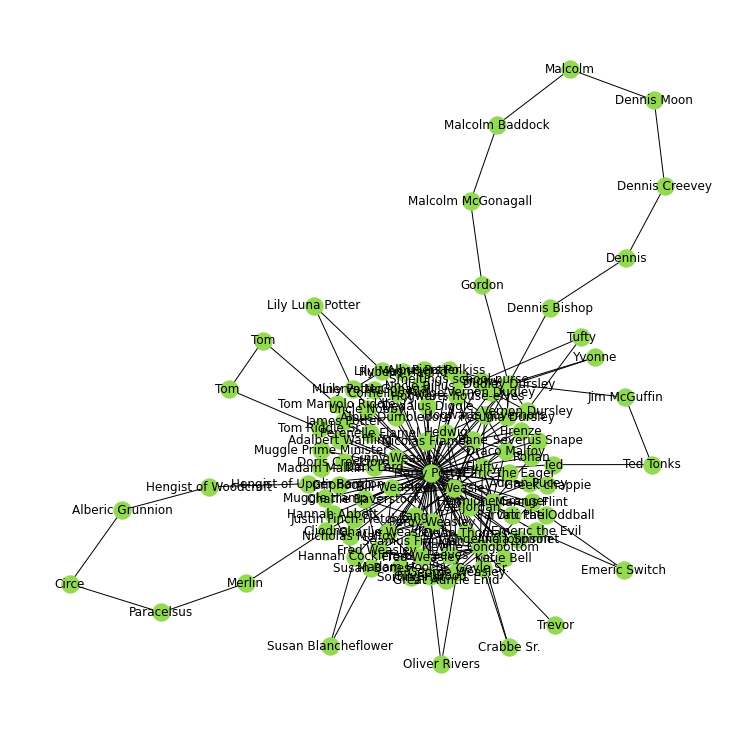

In [35]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='#93d952', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [36]:
# from pyvis.network import Network

# net = Network(height='750px', width='1000px', bgcolor='#222222', font_color='white')

# # set the physics layout of the network
# net.barnes_hut()
# #hp_data = relationship_df

# sources = relationship_df['source']
# targets = relationship_df['target']
# weights = relationship_df['value']

# edge_data = zip(sources, targets, weights)

# for e in edge_data:
#     src = e[0]
#     dst = e[1]
#     w = e[2]

#     net.add_node(src, src, title=src,color='#93d952',alpha=0.3)
#     net.add_node(dst, dst, title=dst,color='#93d952')
#     net.add_edge(src, dst, value=w,color='#93d952')
    
# net.save_graph('weird.html')
    

In [37]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')
#nx.set_edge_attributes(G,color='#93d952',alpha=0.3)

net.from_nx(G)
net.show("philosopherStone.html")

# community detection

In [38]:
communities = community_louvain.best_partition(G)

In [39]:
nx.set_node_attributes(G, communities, 'group')

In [40]:
com_net = Network(notebook = True, width="1000px", height="1000px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("philosopherStone_communities.html")

# Characters throughout books 

In [41]:
from lib.utils.functions2 import *

In [42]:
book_graphs=[]
all_books = [b for b in os.scandir('data')if '.txt' in b.name]

nlp=spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [43]:
# Loop through book list and create graphs
for book in all_books:
    book_text = ner(book)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))
    
    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    ##
    # creating an empty column of lists
    sent_entity_df_filtered['entity_full']=''

    for i in range(sent_entity_df_filtered.shape[0]):
        sent_entity_df_filtered['entity_full'][i]=list(sent_entity_df_filtered['entity_full'][i])
        
    sent_entity_df_filtered=sent_entity_df_filtered.reset_index(drop=True)
   
    #adding the first name for all characters to the column

    for i in range(sent_entity_df_filtered.shape[0]):
        for j in range(len(sent_entity_df_filtered['character_entities'][i])):
            sent_entity_df_filtered['entity_full'][i].append(character_df.loc[( character_df['character'] == sent_entity_df_filtered['character_entities'][i][j])|(character_df['character_firstname'] == sent_entity_df_filtered['character_entities'][i][j]), 'character'].to_list())     
            
    #converting list of list to list in entity full

    for i in range(sent_entity_df_filtered.shape[0]):
        sent_entity_df_filtered['entity_full'][i]=[ item for elem in sent_entity_df_filtered['entity_full'][i] for item in elem]
    ##
                
    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    book_graphs.append(G)

C:\Users\chand\AppData\Local\Temp\ipykernel_17632\3143536251.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['entity_full']=''


KeyError: 0